# Kay 2012, Figure 7
## Taylor Plots

### Function and package imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Interpolation functions with xESMF

In [2]:
from interp_functions import *

#### Taylor plot specific imports

In [3]:
import taylor_jshaw as taylor
import matplotlib as matplotlib
import matplotlib.patches as patches

#### Stats specific imports

In [4]:
import scipy.stats as stats

#### Masking imports

In [5]:
import numpy.ma as ma

### Define functions (some taken from Hillman)

### Find the files

In [6]:
case_dir = '/glade/scratch/jonahshaw/archive/Kay_COSP_2012/'

### Load post-processed CAM4 and CAM5 files into a cloud metric

In [7]:
fig7metric = Cloud_Metric(case_dir)
fig7metric.add_case('cam4_1deg_release_amip',label='CAM4')
fig7metric.add_case('cam5_1deg_release_amip',label='CAM5')

Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...done.
Loading MISR cloud histograms...done.
Loading MODIS cloud histograms...done.
Processed timeseries directory found for cam4_1deg_release_amip. Will load data as required.
cam4_1deg_release_amip load successfully.
Processed timeseries directory found for cam5_1deg_release_amip. Will load data as required.
cam5_1deg_release_amip load successfully.


### Variable loading

In [8]:
model_vars = ['LANDFRAC',
              'SWCF',
              'LWCF',
              'CLDTOT_ISCCP',
              'CLDTOT_CAL',
              'CLDLOW_CAL',
              'CLDMED_CAL',
              'CLDHGH_CAL',
              'CLD_MISR',
              'CLMODIS'
             ]

In [9]:
fig7metric.load_vars(model_vars)

### Grab case_das

In [10]:
cam4_da = fig7metric.get_case('cam4_1deg_release_amip').case_da
cam5_da = fig7metric.get_case('cam5_1deg_release_amip').case_da

### Get land fraction from CAM

In [11]:
landfrac = cam5_da['LANDFRAC'].mean('time')

### Select organized observation data from the metric object

#### Path for pre-processed files:

In [12]:
obs_dir_temp = '/glade/work/jonahshaw/obs/preprocessed/'

### CERES-EBAF cloud feedbacks (2006-2015)

In [13]:
ceres_da = fig7metric.ceres_data

In [14]:
ceres_da = ceres_da.sel(time=slice('2006-01-01', '2010-12-31'))

#### Interpolate to the CESM grid

In [15]:
ceres_interpolated,_ = interp_like2D(ceres_da,cam5_da['SWCF'])

### ISCCP cloud amount (1983-2008)

In [16]:
isccp_da = fig7metric.isccp_data

### CALIOP cloud amount (2006-2015)

In [17]:
caliop_da = fig7metric.goccp_data

### MISR cloud histograms (2005-2020)

In [18]:
misr_da = fig7metric.misr_data

#### Process the Total Cloud MISR histograms (slow and awkward)

In [19]:
if os.path.exists('%s/%s' % (obs_dir_temp,'cam5_CLDTOT_MISR.nc')):
    proc_misr_clt5 = xr.open_dataset('%s/%s' % (obs_dir_temp,'cam5_CLDTOT_MISR.nc'))['CLD_MISR'].mean('time')

else:
    proc_misr_clt5 = cam5_da['CLD_MISR'].where(cam5_da['CLD_MISR'].cosp_tau > 0.3).sum(['cosp_tau','cosp_htmisr'])
    proc_misr_clt5 = proc_misr_clt5.where((landfrac<0.05))

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [20]:
if os.path.exists('%s/%s' % (obs_dir_temp,'cam4_CLDTOT_MISR.nc')):
    proc_misr_clt4 = xr.open_dataset('%s/%s' % (obs_dir_temp,'cam4_CLDTOT_MISR.nc'))['CLD_MISR'].mean('time')

else:
    proc_misr_clt4 = cam4_da['CLD_MISR'].where(cam4_da['CLD_MISR'].cosp_tau > 0.3).sum(['cosp_tau','cosp_htmisr'])
    proc_misr_clt4 = proc_misr_clt4.where((landfrac<0.05))

In [21]:
if os.path.exists('%s/%s' % (obs_dir_temp,'misr_CLDTOT_MISR.nc')):
    proc_misr_clt_obs = xr.open_dataset('%s/%s' % (obs_dir_temp,'misr_CLDTOT_MISR.nc'))['CLD_MISR'].mean('time')

else:
    proc_misr_clt_obs = misr_da['CLD_MISR'].where(misr_da['CLD_MISR'].cosp_tau > 0.3).sum(['cosp_tau','cosp_htmisr'])
    proc_misr_clt_obs = proc_misr_clt_obs.where((landfrac<0.05))

#### Process the low-topped thick MISR histograms (slow and awkward)

In [22]:
if os.path.exists('%s/%s' % (obs_dir_temp,'cam5_CLDLOW_THICK_MISR.nc')):
    proc_misr_cll5 = xr.open_dataset('%s/%s' % (obs_dir_temp,'cam5_CLDLOW_THICK_MISR.nc'))['CLD_MISR'].mean('time')

else:
    cells5 = np.bitwise_and((cam5_da['CLD_MISR'].cosp_tau > 23), (cam5_da['CLD_MISR'].cosp_htmisr < 3))
    proc_misr_cll5 = cam5_da['CLD_MISR'].where(cells5).sum(['cosp_tau','cosp_htmisr'])
    proc_misr_cll5 = proc_misr_cll5.where((landfrac<0.05))

In [23]:
if os.path.exists('%s/%s' % (obs_dir_temp,'cam4_CLDLOW_THICK_MISR.nc')):
    proc_misr_cll4 = xr.open_dataset('%s/%s' % (obs_dir_temp,'cam4_CLDLOW_THICK_MISR.nc'))['CLD_MISR'].mean('time')

else:
    cells4 = np.bitwise_and((cam4_da['CLD_MISR'].cosp_tau > 23), (cam4_da['CLD_MISR'].cosp_htmisr < 3))
    proc_misr_cll4 = cam4_da['CLD_MISR'].where(cells4).sum(['cosp_tau','cosp_htmisr'])
    proc_misr_cll4 = proc_misr_cll4.where((landfrac<0.05))

In [24]:
if os.path.exists('%s/%s' % (obs_dir_temp,'misr_CLDLOW_THICK_MISR.nc')):
    proc_misr_cll_obs = xr.open_dataset('%s/%s' % (obs_dir_temp,'misr_CLDLOW_THICK_MISR.nc'))['CLD_MISR'].mean('time')

else:
    cells_misr = np.bitwise_and((misr_da['CLD_MISR'].cosp_tau > 23), (misr_da['CLD_MISR'].cosp_htmisr < 3))
    proc_misr_cll_obs = misr_da['CLD_MISR'].where(cells_misr).sum(['cosp_tau','cosp_htmisr'])
    proc_misr_cll_obs = proc_misr_cll_obs.where((landfrac<0.05))

### Assign processed data to a new variable

Total cloud

In [25]:
cam5_da['CLDTOT_MISR'] = proc_misr_clt5
cam4_da['CLDTOT_MISR'] = proc_misr_clt4
fig7metric.misr_data['CLDTOT_MISR'] = proc_misr_clt_obs

Low-topped thick cloud

In [26]:
cam5_da['CLDLOW_THICK_MISR'] = proc_misr_cll5
cam4_da['CLDLOW_THICK_MISR'] = proc_misr_cll4
fig7metric.misr_data['CLDLOW_THICK_MISR'] = proc_misr_cll_obs

In [27]:
misr_interpolated,_ = interp_like2D(misr_da,cam5_da['SWCF'])

### MODIS cloud histograms (2002-2010)

In [28]:
modis_da = fig7metric.modis_data
modis_vars = ['CLDHGH_THICK_MODIS']

#### Process the high-topped thick cloud MODIS variable (slow and awkward)

In [29]:
if os.path.exists('%s/%s' % (obs_dir_temp,'cam5_CLDHGH_THICK_MODIS.nc')):
    proc_modis5 = xr.open_dataset('%s/%s' % (obs_dir_temp,'cam5_CLDHGH_THICK_MODIS.nc'))['CLMODIS'].mean('time')

else:
    cells5 = np.bitwise_and((cam5_da['CLMODIS'].cosp_tau_modis > 23),(cam5_da['CLMODIS'].cosp_prs < 440))
    proc_modis5 = cam5_da['CLMODIS'].where(cells5).sum(['cosp_tau_modis','cosp_prs'])

In [30]:
if os.path.exists('%s/%s' % (obs_dir_temp,'cam4_CLDHGH_THICK_MODIS.nc')):
    proc_modis4 = xr.open_dataset('%s/%s' % (obs_dir_temp,'cam4_CLDHGH_THICK_MODIS.nc'))['CLMODIS'].mean('time')

else:
    cells4 = np.bitwise_and((cam4_da['CLMODIS'].cosp_tau_modis > 23), (cam4_da['CLMODIS'].cosp_prs < 440))
    proc_modis4 = cam4_da['CLMODIS'].where(cells4).sum(['cosp_tau_modis','cosp_prs'])

In [31]:
if os.path.exists('%s/%s' % (obs_dir_temp,'modis_CLDHGH_THICK_MODIS.nc')):
    proc_modis_obs = xr.open_dataset('%s/%s' % (obs_dir_temp,'modis_CLDHGH_THICK_MODIS.nc'))['CLMODIS']

else:
    cells_modis = np.bitwise_and((modis_da['CLMODIS'].cosp_tau_modis > 23), (modis_da['CLMODIS'].cosp_prs < 440))
    proc_modis_obs = modis_da['CLMODIS'].where(cells_modis).sum(['cosp_tau_modis','cosp_prs'])

#### Assign high-topped thick cloud MODIS variable

In [64]:
cam5_da['CLDHGH_THICK_MODIS'] = proc_modis5
cam4_da['CLDHGH_THICK_MODIS'] = proc_modis4
fig7metric.modis_data['CLDHGH_THICK_MODIS'] = proc_modis_obs

In [33]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'SWCF': ceres_interpolated,
        'LWCF': ceres_interpolated,
        'CLDTOT_ISCCP': isccp_da,
        'CLDTOT_MISR': misr_interpolated,
        'CLDTOT_CAL': caliop_da,
        'CLDLOW_CAL': caliop_da,
        'CLDMED_CAL': caliop_da,
        'CLDHGH_CAL': caliop_da,
        'CLDLOW_THICK_MISR': misr_interpolated,
        'CLDHGH_THICK_MODIS': modis_da,
    }

# Case names
testnames = ('CAM4','CAM5')
testmetrics = (cam4_da,cam5_da)
testcolors = ('SkyBlue','Firebrick')

# Cloud forcing plot (each sublist is what?)
varlist = (
        ('SWCF','LWCF'),
        ('CLDTOT_ISCCP','CLDTOT_MISR','CLDTOT_CAL'),
        ('CLDLOW_CAL','CLDMED_CAL','CLDHGH_CAL'),
        ('CLDLOW_THICK_MISR','CLDHGH_THICK_MODIS'),
    )

In [34]:
# Fix fonts
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['text.usetex'] = True

In [49]:
def calculate(cntl,test):
    """Calculate Taylor statistics for making taylor diagrams."""

#     test,_ = interp_like2D(test,cntl) # try interpolating first to fix any errors    
    
    _cntl = add_weights(cntl)
    wgt = np.array(_cntl['cell_weight'])
    
#     cntl = np.array(cntl)
#     test = np.array(test)
    
    # calculate sums and means
    sumwgt = np.sum(wgt)
    meantest = np.sum(wgt*test)/sumwgt
    meancntl = np.sum(wgt*cntl)/sumwgt

    # calculate variances
    stdtest = (np.sum(wgt*(test-meantest)**2.0)/sumwgt)**0.5
    stdcntl = (np.sum(wgt*(cntl-meancntl)**2.0)/sumwgt)**0.5

    # calculate correlation coefficient
    ccnum = np.sum(wgt*(test-meantest)*(cntl-meancntl))
    ccdem = sumwgt*stdtest*stdcntl
    corr = ccnum/ccdem

    # calculate variance ratio
    ratio = stdtest/stdcntl

    # calculate bias
    bias = (meantest - meancntl)/np.abs(meancntl)
    #self.bias = meantest - meancntl

    # calculate centered pattern RMS difference
    try:
        rmssum = np.sum(wgt*((test-meantest)-(cntl-meancntl))**2.0)
        
    except:
#         print(meantest.shape,meancntl.shape)
#         print(test.shape,cntl.shape)
#         print(wgt.shape)
#         print((test-meantest).shape)
#         print((cntl-meancntl).shape)
#         print((cntl-meancntl).lon)
#         print((cntl-meancntl).lat)
#         print((test-meantest).lon)
#         print((test-meantest).lat)
        print(((test-meantest)-(cntl-meancntl)).shape)
        print(((test-meantest)-(cntl-meancntl)).lat)
        print(((test-meantest)-(cntl-meancntl)).lon)
    rmserr = (rmssum/sumwgt)**0.5
    rmsnorm = rmserr/stdcntl
    
#     return corr,ratio,bias,rmsnorm
    return bias,corr,rmsnorm,ratio

## Plot CERES CF values

In [50]:
varnames = ['SWCF','LWCF']

nvars = 2; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    
    if 'time' in obs_da[var].coords:
        obs_ds = obs_da[var].mean('time')
    else:
        obs_ds = obs_da[var]
        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics)): # iterate over the models to test/plot
        # Time average:
        test_ds = metric[var].mean('time')
        
        # Calculate Taylor diagram relevant variables:
#         _bias,_corr,_rmsnorm,_ratio = calculate_taylor_values(obs_ds,test_ds)
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
        
#         print(ivar,itest)
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

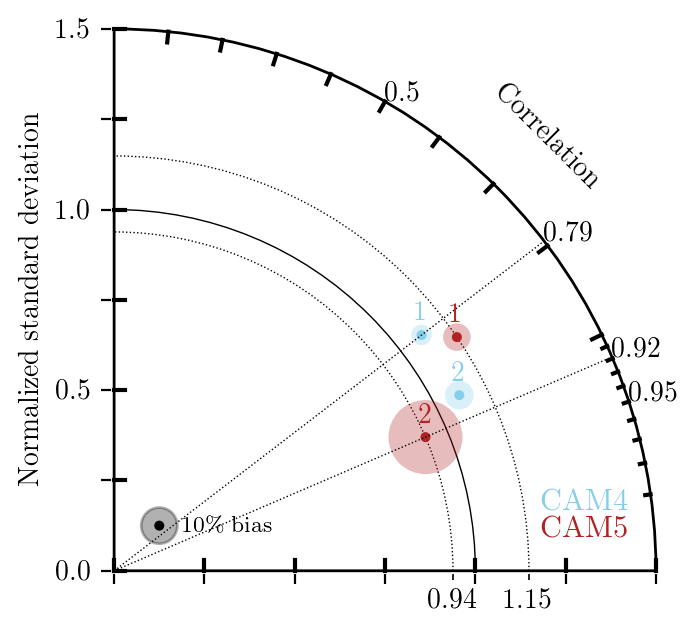

In [51]:
figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )

## Plot ISCCP, MISR, and CALIPSO total cloud

In [58]:
varnames = ['CLDTOT_ISCCP','CLDTOT_MISR']#,'CLDTOT_CAL']

nvars = 2; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    print(var)
    # Select observational dataarray:
    obs_da = cntlnames[var]
    
    if 'time' in obs_da[var].coords:
        obs_ds = obs_da[var].mean('time')
    else:
        obs_ds = obs_da[var]
#     print(obs_ds.shape)
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics)): # iterate over the models to test/plot
        print(name)
        # Time average:
        if 'time' in obs_da[var].coords:
            test_ds = metric[var].mean('time')
        elif 'month' in obs_da[var].coords:
            test_ds = metric[var].mean('month')
#         print(test_ds.shape,obs_ds.shape)
        
        # Calculate Taylor diagram relevant variables:
#         _bias,_corr,_rmsnorm,_ratio = calculate_taylor_values(obs_ds,test_ds)
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
        print(calculate(obs_ds,test_ds))
        
#         print(ivar,itest)
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

CLDTOT_ISCCP
CAM4
(<xarray.DataArray 'CLDTOT_ISCCP' ()>
array(-0.33567808), <xarray.DataArray 'CLDTOT_ISCCP' ()>
array(0.69993971), <xarray.DataArray 'CLDTOT_ISCCP' ()>
array(0.74410535), <xarray.DataArray 'CLDTOT_ISCCP' ()>
array(0.9087659))
CAM5
(<xarray.DataArray 'CLDTOT_ISCCP' ()>
array(-0.21102144), <xarray.DataArray 'CLDTOT_ISCCP' ()>
array(0.85156801), <xarray.DataArray 'CLDTOT_ISCCP' ()>
array(0.60508885), <xarray.DataArray 'CLDTOT_ISCCP' ()>
array(1.15372787))
CLDTOT_MISR
CAM4
(<xarray.DataArray ()>
array(0.26239614), <xarray.DataArray ()>
array(0.33196026), <xarray.DataArray ()>
array(0.92609643), <xarray.DataArray ()>
array(0.75603944))
CAM5
(<xarray.DataArray ()>
array(0.26239614), <xarray.DataArray ()>
array(0.33196026), <xarray.DataArray ()>
array(0.92609643), <xarray.DataArray ()>
array(0.75603944))


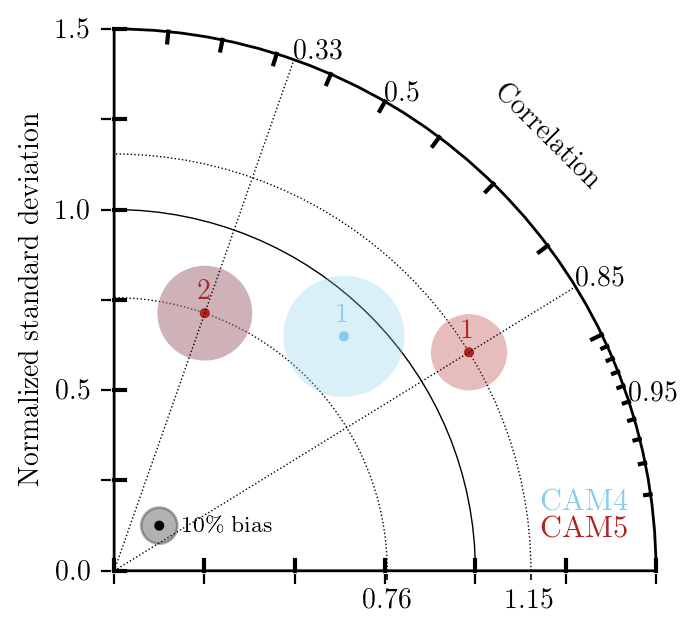

In [59]:
figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )

## Plot CALIPSO low, mid, and high cloud

In [60]:
varnames = ['CLDLOW_CAL','CLDMED_CAL','CLDHGH_CAL']#,'CLDTOT_CAL']

nvars = 3; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    print(var)
    # Select observational dataarray:
    obs_da = cntlnames[var]
    
    if 'time' in obs_da[var].coords:
        obs_ds = obs_da[var].mean('time')
    else:
        obs_ds = obs_da[var]
#     print(obs_ds.shape)
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics)): # iterate over the models to test/plot
        print(name)
        # Time average:
        if 'time' in obs_da[var].coords:
            test_ds = metric[var].mean('time')
        elif 'month' in obs_da[var].coords:
            test_ds = metric[var].mean('month')
#         print(test_ds.shape,obs_ds.shape)
        
        # Calculate Taylor diagram relevant variables:
#         _bias,_corr,_rmsnorm,_ratio = calculate_taylor_values(obs_ds,test_ds)
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
        print(calculate(obs_ds,test_ds))
        
#         print(ivar,itest)
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

CLDLOW_CAL


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM4
(95, 288)
<xarray.DataArray 'lat' (lat: 95)>
array([-90.      , -89.057592, -88.115183, -87.172775, -86.230366, -85.287958,
       -84.34555 , -83.403141, -82.460733, -81.518325, -80.575916, -79.633508,
       -78.691099, -77.748691, -76.806283, -75.863874, -74.921466, -73.979058,
       -73.036649, -72.094241, -70.209424, -68.324607, -67.382199, -66.439791,
       -65.497382, -64.554974, -63.612565, -62.670157, -61.727749, -59.842932,
       -58.900524, -57.958115, -57.015707, -56.073298, -55.13089 , -54.188482,
       -53.246073, -52.303665, -51.361257, -50.418848, -49.47644 , -48.534031,
       -47.591623, -46.649215, -45.706806, -44.764398, -43.82199 , -42.879581,
       -41.937173, -40.994764, -40.052356, -39.109948, -38.167539, -37.225131,
       -36.282723, -35.340314, -34.397906, -33.455497, -32.513089, -30.628272,
       -29.685864, -28.743455, -24.031414, -22.146597, -17.434555, -15.549738,
        -8.95288 ,   4.240838,  10.837696,  17.434555,  24.031414,  30.628272,
  

UnboundLocalError: local variable 'rmssum' referenced before assignment

IndexError: range object index out of range

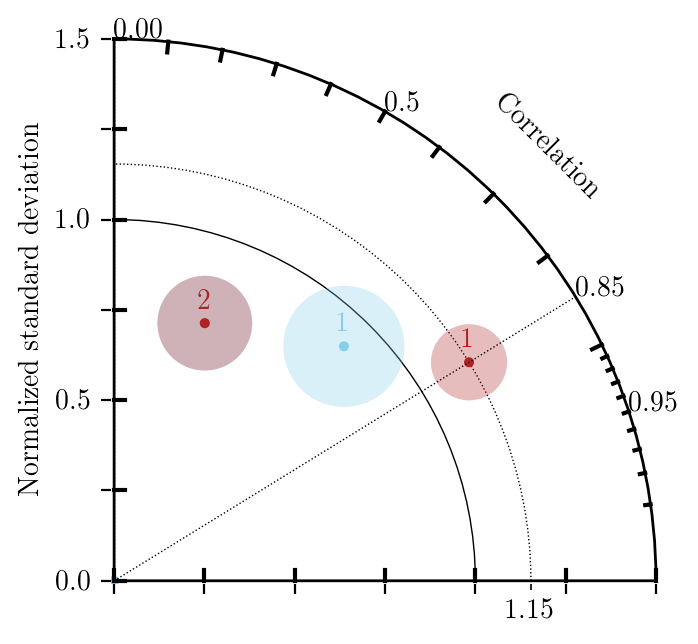

In [54]:
figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )

## Plot thick cloud, MISR low-topped and MODIS high-topped

In [79]:
varnames = ['CLDLOW_THICK_MISR','CLDHGH_THICK_MODIS']#,'CLDTOT_CAL']

nvars = 2; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    print(var)
    # Select observational dataarray:
    obs_da = cntlnames[var]
    
    if 'time' in obs_da[var].coords:
        try:
            obs_ds = obs_da[var].mean('time')
        except:
            obs_ds = obs_da[var]   
    else:
        obs_ds = obs_da[var]
#     print(obs_ds.shape)
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics)): # iterate over the models to test/plot
        print(name)
        # Time average:
        if 'time' in obs_da[var].coords:
            try:
                test_ds = metric[var].mean('time')
            except:
                pass
        elif 'month' in obs_da[var].coords:
            test_ds = metric[var].mean('month')
        else:
            test_ds = metric[var]
#         print(test_ds.shape,obs_ds.shape)
        
        # Calculate Taylor diagram relevant variables:
#         _bias,_corr,_rmsnorm,_ratio = calculate_taylor_values(obs_ds,test_ds)
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
        print(calculate(obs_ds,test_ds))
        
#         print(ivar,itest)
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

CLDLOW_THICK_MISR
CAM4
(<xarray.DataArray 'CLDLOW_THICK_MISR' ()>
array(1.23519882), <xarray.DataArray 'CLDLOW_THICK_MISR' ()>
array(0.68905325), <xarray.DataArray 'CLDLOW_THICK_MISR' ()>
array(1.34479539), <xarray.DataArray 'CLDLOW_THICK_MISR' ()>
array(1.86644539))
CAM5
(<xarray.DataArray 'CLDLOW_THICK_MISR' ()>
array(0.59623342), <xarray.DataArray 'CLDLOW_THICK_MISR' ()>
array(0.81832952), <xarray.DataArray 'CLDLOW_THICK_MISR' ()>
array(0.96390161), <xarray.DataArray 'CLDLOW_THICK_MISR' ()>
array(1.63447222))
CLDHGH_THICK_MODIS
CAM4
(<xarray.DataArray ()>
array(-0.43269676)
Coordinates:
    time     object 2000-01-01 00:00:00, <xarray.DataArray ()>
array(0.25890488)
Coordinates:
    time     object 2000-01-01 00:00:00, <xarray.DataArray ()>
array(1.09653751)
Coordinates:
    time     object 2000-01-01 00:00:00, <xarray.DataArray ()>
array(1.00726135)
Coordinates:
    time     object 2000-01-01 00:00:00)
CAM5
(<xarray.DataArray ()>
array(-0.43269676)
Coordinates:
    time     object 

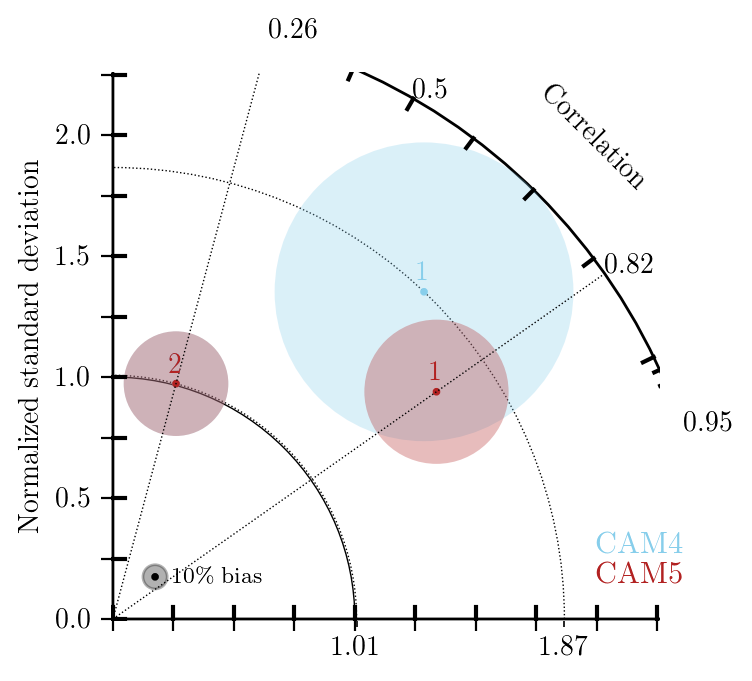

In [80]:
figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )

# Old Stuff

In [38]:
# https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Weighted_correlation_coefficient
# Source^

def weighted_mean(a,weights):
    '''Calculate the weighted mean of a dataset.'''
    
    weight_sum = np.sum(weights)
    mean = np.sum(a*weights)/weight_sum
    
    return mean

def weighted_standard_deviation(a,weights):
    '''Calculate the weighted standard deviation of a dataset.'''
    
    weight_sum = np.sum(weights)
    mean = weighted_mean(a,weights)
    
    std = np.sqrt(np.sum(weights*(a-mean)**2)/weight_sum)
    
    return std

def weighted_covariance(a,b,weights_a,weights_b):
    '''Calculate the weighted covariance between two datasets.'''
    
    mean_a = weighted_mean(a,weights_a)
    mean_b = weighted_mean(b,weights_b)
    
    cov = np.sum(weights_a*(a-mean_a)*(b-mean_b)) / np.sum(weights_a)
    
    return cov

def weighted_pearson_correlation(a,b,weights_a,weights_b):
    '''Calculate the weighted pearson correlation coefficient of two datasets.'''
    
    # calculate correlation coefficient
    ccnum = np.sum(weights_a*(a-weighted_mean(a))*(b-weighted_mean(b)))
    ccdem = np.sum(weights_a)*stdtest*stdcntl
    corr = ccnum/ccdem
    
#     corr = weighted_covariance(a,b,weights_a,weights_b) / np.sqrt(weighted_covariance(a,a,weights_a,weights_b)*weighted_covariance(b,b,weights_a,weights_b))
    
    return corr

def weighted_centered_rms_error(a,b,weights_a,weights_b):
    '''Calculate the weighted root-mean-square error of two datasets.'''

    weight_sum = np.sum(weights_a)
    mean_a = weighted_mean(a,weights_a)    
    mean_b = weighted_mean(b,weights_b)
    
    rmssum = np.sum(weights_a*((a-mean_a)-(b-mean_b))**2)
    rmserr = np.sqrt(rmssum / weight_sum)
    
    return rmserr

In [40]:
def shared_mask(a,b):
    '''return masked arrays that are masked wherever a nan value is found.'''

    nans_a = (a == np.nan)
    nans_b = (b == np.nan)
    mask = np.bitwise_or(nans_a,nans_b)
    print(mask)
    a_masked = ma.array(a,mask=mask)    
    b_masked = ma.array(b,mask=mask)
    
    return a_masked,b_masked

In [41]:
def calculate_taylor_values(obs,model):
    '''
    Calculate the values needed to make a Taylor plot for a given set of
    observations and modelled results. Assume they are already 
    interpolated and time averaged.
    '''
    
    obs = add_weights(obs)
    obs_weights = np.array(obs['cell_weight'])
    model = add_weights(model)
    model_weights = np.array(model['cell_weight'])
    
#     print(weighted_mean(model,model_weights))
#     print(weighted_mean(obs,obs_weights))

    # fractional bias
    bias = (weighted_mean(model,model_weights) - weighted_mean(obs,obs_weights))/np.abs(weighted_mean(obs,obs_weights))
    
    # pearson correlation coefficient
    corr = weighted_pearson_correlation(obs,model,obs_weights,model_weights)
    
    # centered RMS error
    rmserr = weighted_centered_rms_error(obs,model,obs_weights,model_weights)
    rmsnorm = rmserr / weighted_standard_deviation(obs,obs_weights)
    
    # variance ratio (std ratio) (not sure why?)
    ratio = weighted_standard_deviation(obs,obs_weights) / weighted_standard_deviation(model,model_weights)
    
    return bias,corr,rmsnorm,ratio

In [ ]:
figure = plt.figure()
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,corr,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,2+1),
        )

In [60]:
a1,a2 = shared_mask(ceres_interpolated['SWCF'],cam4_da['SWCF'])

<xarray.DataArray 'SWCF' (lat: 0, lon: 72)>
array([], shape=(0, 72), dtype=bool)
Coordinates:
  * lat      (lat) float64 
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5


MaskError: Mask and data not compatible: data size is 64800, mask size is 0.

In [ ]:
# calculate sums and means
sumwgt = np.ma.sum(wgt) # total weight
meantest = np.ma.sum(wgt*test)/sumwgt # weighted global average
meancntl = np.ma.sum(wgt*cntl)/sumwgt # weighted global average

# calculate variances (these are standard deviations, though)
stdtest = (np.ma.sum(wgt*(test-meantest)**2.0)/sumwgt)**0.5
stdcntl = (np.ma.sum(wgt*(cntl-meancntl)**2.0)/sumwgt)**0.5

# calculate correlation coefficient
ccnum = np.ma.sum(wgt*(test-meantest)*(cntl-meancntl))
ccdem = sumwgt*stdtest*stdcntl
self.cc = ccnum/ccdem

# calculate variance ratio <-- standard deviation ratio??
self.ratio = stdtest/stdcntl

# calculate bias as a fraction of the observations
self.bias = (meantest - meancntl)/np.abs(meancntl)
#self.bias = meantest - meancntl

# calculate centered pattern RMS difference
rmssum = np.ma.sum(wgt*((test-meantest)-(cntl-meancntl))**2.0)
rmserr = (rmssum/sumwgt)**0.5
self.rmsnorm = rmserr/stdcntl

('SWCF', 'LWCF')
SWCF
    variable: SWCF, case: CAM4
nearest neighbor interpolation starting...done.
nearest neighbor interpolation starting...done.
    variable: SWCF, case: CAM5
nearest neighbor interpolation starting...done.
nearest neighbor interpolation starting...done.
LWCF
time averaging
    variable: LWCF, case: CAM4
time averaging
nearest neighbor interpolation starting...done.
nearest neighbor interpolation starting...done.
    variable: LWCF, case: CAM5
nearest neighbor interpolation starting...done.
nearest neighbor interpolation starting...done.
self.xymax:  1.5
('CLDTOT_ISCCP', 'CLDTOT_MISR', 'CLDTOT_CAL')
CLDTOT_ISCCP
time averaging
    variable: CLDTOT_ISCCP, case: CAM4
time averaging
nearest neighbor interpolation starting...done.
nearest neighbor interpolation starting...done.
    variable: CLDTOT_ISCCP, case: CAM5
nearest neighbor interpolation starting...done.
nearest neighbor interpolation starting...done.
CLDTOT_MISR
    variable: CLDTOT_MISR, case: CAM4
nearest n

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Warning: converting a masked element to nan.
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Warning: converting a masked element to nan.


done.
nearest neighbor interpolation starting...done.
CLDTOT_CAL
time averaging
    variable: CLDTOT_CAL, case: CAM4
time averaging


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


nearest neighbor interpolation starting...done.
nearest neighbor interpolation starting...done.
    variable: CLDTOT_CAL, case: CAM5
nearest neighbor interpolation starting...done.
nearest neighbor interpolation starting...done.
self.xymax:  nan


ValueError: arange: cannot compute length

posx and posy should be finite values
posx and posy should be finite values


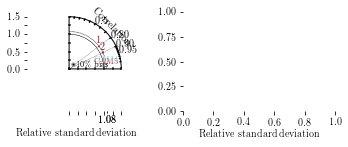

In [31]:
    # Make plot
    ax = figure.add_subplot(2,2,iplot+1,frameon=False)
    taylor_diagram = taylor.Taylor_diagram(
            ax,cc,ratio,bias,
            casecolors=testcolors,
            varlabels=range(1,nvars+1),
        )

    # Reference bias bubbles, wut is this?
    ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
    yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
    xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
    circle = patches.Circle(
            (xloc,yloc),ref_bias/2.0,
            color="black",
            alpha=0.30,
        )
    ax.add_patch(circle)

    # Reference bias bubble points - centered at the reference bubble
    circle = patches.Circle(
            (xloc,yloc),0.01,
            color="black",
        )
    ax.add_patch(circle)

    # Reference bias text
    ax.text(
            xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
            "%.0f%s bias"%(ref_bias*100,r"\%"),
            color="Black",
            fontsize=8,
            horizontalalignment="left",
            verticalalignment="center"
        )

    # Case labels
    xloc = taylor_diagram.xymax*0.95
    yloc = taylor_diagram.xymax*0.05
    dy = taylor_diagram.xymax*0.05
    for itest,testname in enumerate(testnames[::-1]):
        ax.text(
                xloc,yloc+itest*dy, # place these just above the dots
                testname,
                color=testcolors[::-1][itest],
                fontsize=8,
                horizontalalignment="right",
                verticalalignment="bottom",
            )